## `ConvLSTM` (`roll-out`) Inference 
* the aim of this notebook is to run inference on trained `ConvLSTM()` models that makes roll-out predictions.

In [13]:
import os
from pathlib import Path
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib.colors import ListedColormap
from scipy import io
from torch.utils.data import DataLoader

from rainnow.src.conv_lstm_utils import IMERGDataset, create_eval_loader
from rainnow.src.models.conv_lstm import ConvLSTMModel
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import (
    get_device,
    transform_minus1_1_to_0_1,
)

#### `Helpers.`

In [14]:
# ** plotting helpers **
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("/teamspace/studios/this_studio/irp-ds423/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

No GPU available! (device = cpu)


In [15]:
# ** DIR helpers **
CKPT_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/results/"
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
# CKPT_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
# CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataloader Params **
BATCH_SIZE = 6
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1

#### `Datasets & Dataloaders`

In [4]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)

# get the .data_<split>
# datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

[2024-08-29 12:38:19][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 12:38:19][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-29 12:40:32][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-29 12:40:32][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 12:40:33][abstract_datamodule.py][INFO] -->  Dataset test size: 851
[2024-08-29 12:40:33][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 12:40:33][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-08-29 12:42:44][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-08-29 12:42:44][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 12:42:44

In [5]:
# create the datasets.
# val_dataset = IMERGDataset(
#     datamodule, "validate", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
# )
test_dataset = IMERGDataset(
    datamodule, "test", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)

# instantiate the dataloaders.
# val_loader = DataLoader(
#     dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
# )
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

#### `Instantiate a preproccessor object`

In [6]:
# ** instantiate the preprocesser obj **
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-29 12:42:44][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


#### `Instantiate a ConvLSTM()`

In [7]:
ckpt_ids = {
    # rollout ConvLSTM.
    "convlstm-z6nt4yvq": "I4:T1 | hs=(128, 64), ks=(5, 5), dp=.15 [20E, lr=3e-4] LPIPS",
    "convlstm-abcd1234": "** conv_lstm_hc_128128_ks_5_oa_Tanh.pt ** I4:T1 | hs=(128, 128), ks=(5, 5), dp=.15 [20E, lr=3e-4] LPIPS",
    "convlstm-a8kwo8jx": "I4:T1 | hs=(128, 128), ks=(5, 5), dp=.15 [20E, lr=3e-4] BCE",
}

In [8]:
# ** load in checkpoint **
# ckpt_id = "convlstm-z6nt4yvq"
# ckpt_id = "convlstm-a8kwo8jx"
ckpt_id = "convlstm-abcd1234"

model_save_path = Path(
    os.path.join(CKPT_BASE_PATH, "convlstm_experiments", ckpt_id, "checkpoints", f"{ckpt_id}.pt")
)

In [9]:
# ** instantiate a new model **

KERNEL_SIZE = (5, 5)
INPUT_DIMS = (1, 128, 128)  # C, H, W
OUTPUT_CHANNELS = 1
HIDDEN_CHANNELS = [128, 128]
NUM_LAYERS = 2
CELL_DROPOUT = 0.15
OUTPUT_ACTIVATION = nn.Tanh()  # nn.Sigmoid()

model = ConvLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    input_dims=INPUT_DIMS,
    hidden_channels=HIDDEN_CHANNELS,
    output_channels=OUTPUT_CHANNELS,
    num_layers=NUM_LAYERS,
    kernel_size=KERNEL_SIZE,
    output_activation=OUTPUT_ACTIVATION,
    apply_batchnorm=True,
    cell_dropout=CELL_DROPOUT,
    bias=True,
    device=device,
)

model = model.to(device)

# load in the checkpoint.
model.load_state_dict(
    state_dict=torch.load(model_save_path, map_location=torch.device(device))["model_state_dict"]
)

# set model into eval mode.
model.eval()

ConvLSTMModel(
  (output_activation): Tanh()
  (convlstm): ConvLSTM(
    (output_activation): Tanh()
    (conv_lstm_cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv_input_and_hidden_to_cell): Sequential(
          (0): Conv2d(129, 512, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout(p=0.15, inplace=False)
        )
      )
      (1): ConvLSTMCell(
        (conv_input_and_hidden_to_cell): Sequential(
          (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout(p=0.15, inplace=False)
        )
      )
    )
    (conv_hidden_to_output): Sequential(
      (0): Conv2d(128, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
    )
  )
)

#### `Get inputs, X and predict.`

In [10]:
# ** create the eval dataloader **
eval_loader, _ = create_eval_loader(
    data_loader=predict_loader, horizon=8, input_sequence_length=4, img_dims=(128, 128)
)

** eval loader (INFO) **
Num samples = 11 w/ dims: torch.Size([12, 1, 128, 128])



In [11]:
results = []
with torch.no_grad():
    for e, (X, target) in enumerate(eval_loader[:1]):
        predictions = {}
        # predict t+1
        _input = X.clone().unsqueeze(0).to(device)

        for t in range(target.size(0)):
            pred = model(_input)
            if isinstance(model.output_activation, nn.Tanh):
                pred = transform_minus1_1_to_0_1(pred)

            predictions[f"t{t+1}"] = pred.squeeze(0)

            # update the inputs with the last pred.
            _input = torch.concat([_input[:, 1:, ...], pred], dim=1)

        results.append([target, predictions])

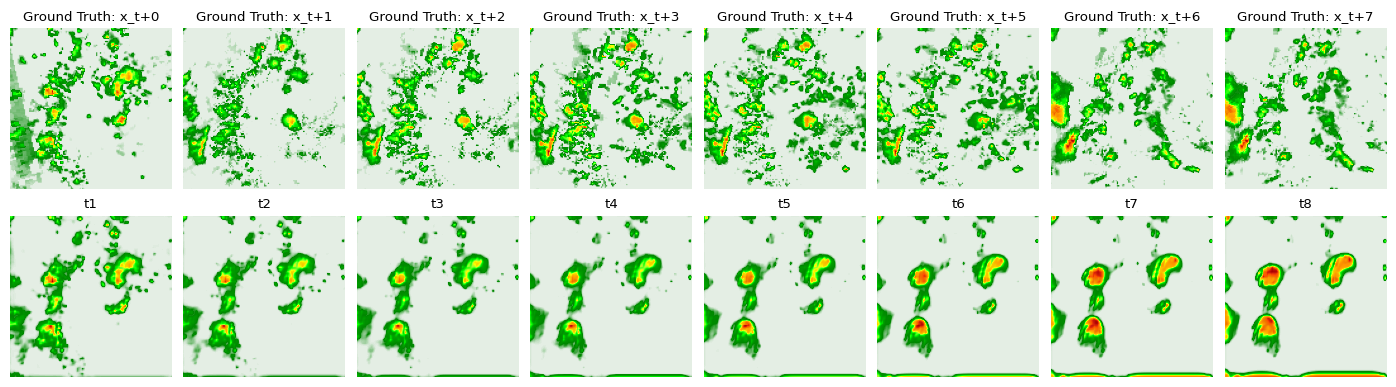

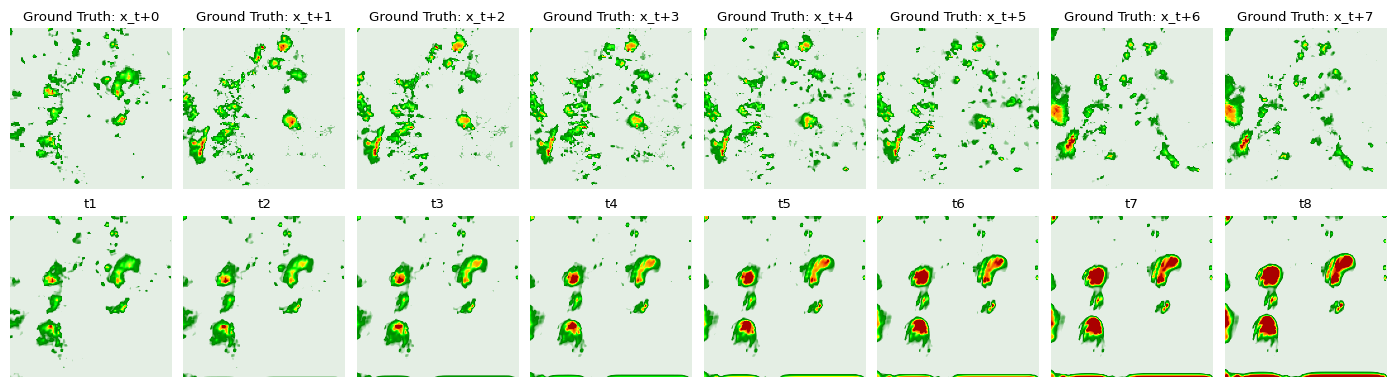

In [12]:
c = 0
figsize = (14, 4)
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 18}
idx = 0
targets, predictions = results[idx]

# get raw scale.
target_reversed = pprocessor.reverse_processing(targets).cpu().detach()
preds_reversed = {k: pprocessor.reverse_processing(v) for k, v in predictions.items()}

fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(targets[j, c, ...], **{"cmap": rain_cmap})
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, (k, pred) in enumerate(predictions.items()):
    axs[1, e].imshow(pred[0, c, :, :], **{"cmap": rain_cmap})
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

# raw scale.
fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(target_reversed[j, c, ...], **plot_params)
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, (k, pred) in enumerate(preds_reversed.items()):
    axs[1, e].imshow(pred[0, c, :, :], **plot_params)
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

### END OF SCRIPT.